In [1]:
import gym
from stable_baselines3 import DQN, PPO
from __future__ import division
import numpy as np

from gym.utils import seeding
import sys, os
import matplotlib.pyplot as plt

from toricgame_env import ToricGameEnv

In [241]:
class Board(object):
    '''
    Basic Implementation of a ToricGame Board, actions are int [0,2*board_size**2)
    o : qubit
    P : plaquette operator
    x : star operator
    x--o---x---o---x---o---
    |      |       |
    o  P   o   P   o   P
    |      |       |
    x--o---x---o---x---o---
    |      |       |
    o  P   o   P   o   P
    |      |       |
    x--o---x---o---x---o---
    |      |       |
    o  P   o   P   o   P
    |      |       |
    '''
    @staticmethod
    def component_positions(size):
        qubit_pos   = [[x,y] for x in range(2*size) for y in range((x+1)%2, 2*size, 2)]
        plaquet_pos = [[x,y] for x in range(1,2*size,2) for y in range(1,2*size,2)]
        star_pos    = [[x,y] for x in range(0,2*size,2) for y in range(0,2*size,2)]

        return qubit_pos, plaquet_pos, star_pos

    def __init__(self, board_size):
        # Store size
        self.size = board_size

        # Real-space locations
        self.qubit_pos, self.plaquet_pos, self.star_pos  = self.component_positions(self.size)

        # Define here the logical error for efficiency
        self.z1pos = [[0,x] for x in range(1, 2*self.size, 2)]
        self.z2pos = [[y,0] for y in range(1, 2*self.size, 2)]
        self.x1pos = [[1,x] for x in range(0, 2*self.size, 2)]
        self.x2pos = [[y,1] for y in range(0, 2*self.size, 2)]

        # Reset board
        self.reset()

    def reset(self):
        # The physical qubits
        self.qubit_values = np.zeros((2, 2*self.size*self.size))
        # The stabilizers
        self.op_values = np.zeros((2, self.size*self.size))

        # Location of syndromes
        self.syndrome_pos = [] 

    def act(self, coord, operator, update_syndrome = True):
        '''
            Args: 
            coord: real-space location (x,y) of the qubit to flip
            operator: the operator to apply to the qubit (Pauli X, Y, or Z)
        '''

        pauli_X_flip = (operator==0 or operator==2)
        pauli_Z_flip = (operator==1 or operator==2)

        # Get qubit index
        qubit_index = self.qubit_pos.index(coord)

        # Apply operator
        if pauli_X_flip:
            self.qubit_values[0][qubit_index] = (self.qubit_values[0][qubit_index] + 1) % 2
        if pauli_Z_flip:
            self.qubit_values[1][qubit_index] = (self.qubit_values[1][qubit_index] + 1) % 2

        if not update_syndrome:
            return
            
        # Update the syndrome measurements
        # Only need to incrementally change
        # Find plaquettes that the flipped qubit is a part of
        plaqs=[]
        if pauli_X_flip:
            if coord[0] % 2 == 0:
                plaqs += [ [ (coord[0] + 1) % (2*self.size), coord[1] ], [ (coord[0] - 1) % (2*self.size), coord[1] ] ]
            else:
                plaqs += [ [ coord[0], (coord[1] + 1) % (2*self.size) ], [ coord[0], (coord[1] - 1) % (2*self.size) ] ]

        if pauli_Z_flip:
            if coord[0] % 2 == 0:
                plaqs += [ [ coord[0], (coord[1] + 1) % (2*self.size) ], [ coord[0], (coord[1] - 1) % (2*self.size) ] ]
            else:
                plaqs += [ [ (coord[0] + 1) % (2*self.size), coord[1] ], [ (coord[0] - 1) % (2*self.size), coord[1] ] ]


        # Update syndrome positions
        channel = None
        for plaq in plaqs:
            if plaq in self.syndrome_pos:
                self.syndrome_pos.remove(plaq)
            else:
                self.syndrome_pos.append(plaq)

            # The plaquette or vertex operators are only 0 or 1
            if plaq in self.star_pos:
                op_index = self.star_pos.index(plaq)
                channel = 1
            elif plaq in self.plaquet_pos:
                op_index = self.plaquet_pos.index(plaq)
                channel = 0

            self.op_values[channel][op_index] = (self.op_values[channel][op_index] + 1) % 2


    def is_terminal(self):
        # Are all syndromes removed?
        return len(self.syndrome_pos) == 0

    def has_logical_error(self, initialmoves, verbose=False):
        if verbose:
            print("Initial errors:", [self.qubit_pos.index(q) for q in initialmoves])

        # Check for Z logical error
        zerrors = [0,0]
        for pos in self.z1pos:
            if pos in initialmoves[0]:
                zerrors[0] += 1
            qubit_index = self.qubit_pos.index(pos)
            zerrors[0] += self.qubit_values[0][ qubit_index ]

        for pos in self.z2pos:
            if pos in initialmoves[0]:
                zerrors[1] += 1
            qubit_index = self.qubit_pos.index(pos)
            zerrors[1] += self.qubit_values[0][ qubit_index ]

        # Check for X logical error
        xerrors = [0,0]
        for pos in self.x1pos:
            if pos in initialmoves[1]:
                xerrors[0] += 1
            qubit_index = self.qubit_pos.index(pos)
            xerrors[0] += self.qubit_values[1][ qubit_index ]

        for pos in self.x2pos:
            if pos in initialmoves[1]:
                xerrors[1] += 1
            qubit_index = self.qubit_pos.index(pos)
            xerrors[1] += self.qubit_values[1][ qubit_index ]

        if (zerrors[0]%2 == 1) or (zerrors[1]%2 == 1) or \
            (xerrors[0]%2 == 1) or (xerrors[1]%2 == 1):
            return True

        return False

    def encode(self, error_model):
        '''
        Returns a representation of the board
        
        Args: 
            error_model: 0 for uncorrelated (bitflip), 1 for depolarizing
        '''
        img = np.array([])
        # Add plaquette values
        img = np.concatenate((img, self.op_values[0]))
        # Add z-values of qubits
        img = np.concatenate((img, self.qubit_values[0]))
        
        if error_model == 1:
            # Add star values
            img = np.concatenate((img, self.op_values[1]))
            # Add x-values of qubits
            img = np.concatenate((img, self.qubit_values[1]))

        return np.array([int(i) for i in img])

In [242]:
### Environment
class ToricGameEnv(gym.Env):
    '''
    ToricGameEnv environment. Effective single player game.
    '''

    def __init__(self, board_size, error_rate, error_model, allow_illegal_actions = False):
        """
        Args:
            board_size: Size of the Toric code (distance)
            error_rate: The physical qubit error rate
            error_model: 0 for bitflip, or 1 for depolarizing
        """
        self.board_size = board_size
        self.error_rate = error_rate
        self.error_model = error_model
        self.allow_illegal_actions = allow_illegal_actions 
        
        # Create a new board
        self.state = Board(self.board_size)
        # Reset the environment
        initial_state = self.reset()

        # Compute the action space
        num_qubits_to_act_on = 2*self.board_size**2
        num_pauli_operators = 1 if error_model == 0 else 3
        self.action_space = gym.spaces.Discrete(num_qubits_to_act_on*num_pauli_operators)
        
        # Compute the observation space
        self.observation_space = gym.spaces.MultiBinary(len(initial_state)) #gym.spaces.Box(low=0.0, high=1.0, shape=(len(initial_state),), dtype=np.float32)
        
        # Game over after max number of steps
        self.max_steps = num_qubits_to_act_on

    def reset(self):        
        # Reset the board state
        self.state.reset()
        
        # Reset number of steps taken
        self.num_steps_taken = 0

        # Reset the initial errors
        self.qubits_flips = [[],[]]
        self.initial_qubits_flips = [[],[]]
        # Set initial errors
        self._set_initial_errors(self.error_rate)

        # Make sure we always have *some* errors
        while self.state.is_terminal():
             # Reset the initial errors
            self.qubits_flips = [[],[]]
            self.initial_qubits_flips = [[],[]]

            # Set initial errors
            self._set_initial_errors(self.error_rate)

        return self.state.encode(self.error_model)

    def step(self, action): 
        '''
        Args:
            action: the action to take (will be decompsed into location and operator)
                    location: coord of the qubit to act on
                    pauli_opt: pauli operator to apply to the qubit
        Return:
            observation: board encoding
            reward: reward of the game
            done: boolean indicating whether the game is over or not
            info: state dict with possible extra info
        '''        
        if( self.num_steps_taken > self.max_steps ):
            return self.state.encode(self.error_model), -1.0, True, {'state': self.state, 'message':"too many steps"}
        
        # Increase step number
        self.num_steps_taken += 1
        
        # Convert action integer to coordinates and operator
        if( self.error_model == 0 ):
            location = self.state.qubit_pos[action]
            pauli_opt = 0
            
        if( self.error_model == 1 ):
            pauli_opt = action // (2*self.board_size**2)
            action = action % (2*self.board_size**2)
            location = self.state.qubit_pos[action]
        
        # Get operator
        pauli_X_flip = (pauli_opt==0 or pauli_opt==2)
        pauli_Z_flip = (pauli_opt==1 or pauli_opt==2)
        
        # If we end after an illegal action...
        if not self.allow_illegal_actions:
            if pauli_X_flip and location in self.qubits_flips[0]:
                return self.state.encode(self.error_model), -1.0, True, {'state': self.state, 'message': "illegal_action"}
            if pauli_Z_flip and location in self.qubits_flips[1]:
                return self.state.encode(self.error_model), -1.0, True, {'state': self.state, 'message': "illegal_action"}

        # Keep track of the actions
        if pauli_X_flip:
            self.qubits_flips[0].append(location)
        if pauli_Z_flip:
            self.qubits_flips[1].append(location)
            
        # Apply the operator
        self.state.act(location, pauli_opt)

        # Reward: if nonterminal, then the reward is 0
        if not self.state.is_terminal():
            return self.state.encode(self.error_model), 0., False, {'state': self.state, 'message':"continue"}

        # We're in a terminal state. Reward is 1 if won, -1 if lost
        if self.state.has_logical_error(self.initial_qubits_flips):
            return self.state.encode(self.error_model), -1.0, True, {'state': self.state, 'message':"logical_error"}
        else:
            return self.state.encode(self.error_model), 1.0, True, {'state': self.state, 'message':"success"}
                
    def _set_initial_errors(self, error_rate=None):
        ''' 
            Set random initial errors with an %error_rate rate
            Report only the syndrome
        '''
        # Use the instance error rate if not specified (i.e. specify to override)
        error_rate = self.error_rate if error_rate == None else error_rate
        
        for q in self.state.qubit_pos:
            if np.random.rand() < error_rate:
                # Bitflip
                if self.error_model == 0:
                    pauli_opt = 0
                # Depolarizing
                elif self.error_model == 1:
                    pauli_opt = np.random.randint(0,3)

                pauli_X_flip = (pauli_opt==0 or pauli_opt==2)
                pauli_Z_flip = (pauli_opt==1 or pauli_opt==2)

                if pauli_X_flip:
                    self.initial_qubits_flips[0].append( q )
                if pauli_Z_flip:
                    self.initial_qubits_flips[1].append( q )

                self.state.act(q, pauli_opt)

        # Now unflip the qubits, they're a secret
        self.state.qubit_values = np.zeros((2, 2*self.board_size*self.board_size))
            
    def render(self, mode="human"):
        fig, ax = plt.subplots()
        a=1/(2*self.board_size)

        for i, p in enumerate(self.state.plaquet_pos):
            if self.state.op_values[0][i]==1:
                fc='darkorange'
                plaq = plt.Polygon([[a*p[0], a*(p[1]-1)], [a*(p[0]+1), a*(p[1])], [a*p[0], a*(p[1]+1)], [a*(p[0]-1), a*p[1]] ], fc=fc)
                ax.add_patch(plaq)

        for i, p in enumerate(self.state.star_pos):
            if self.state.op_values[1][i]==1:
                fc = 'green'
                plaq = plt.Polygon([[a*p[0], a*(p[1]-1)], [a*(p[0]+1), a*(p[1])], [a*p[0], a*(p[1]+1)], [a*(p[0]-1), a*p[1]] ], fc=fc)
                ax.add_patch(plaq)

        # Draw lattice
        for x in range(self.board_size):
            for y in range(self.board_size):
                pos=(2*a*x, 2*a*y)
                width=a*2
                lattice = plt.Rectangle( pos, width, width, fc='none', ec='black' )
                ax.add_patch(lattice)

        for i, p in enumerate(self.state.qubit_pos):
            pos=(a*p[0], a*p[1])
            fc='darkgrey'
            if self.state.qubit_values[0][i] == 1 and self.state.qubit_values[1][i] == 0:
                fc='darkblue'
            elif self.state.qubit_values[0][i] == 0 and self.state.qubit_values[1][i] == 1:
                fc='darkred'
            elif self.state.qubit_values[0][i] == 1 and self.state.qubit_values[1][i] == 1:
                fc='darkmagenta'
            circle = plt.Circle( pos , radius=a*0.25, ec='k', fc=fc)
            ax.add_patch(circle)
            plt.annotate(str(i), pos, fontsize=8, ha="center")

        ax.set_xlim([-.1,1.1])
        ax.set_ylim([-.1,1.1])
        ax.set_aspect(1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis('off')
        plt.show()
        
    def close(self):
        self.state = None


## Play the game

In [2]:
env = ToricGameEnv(3, 0.01, 0, allow_illegal_actions=True)

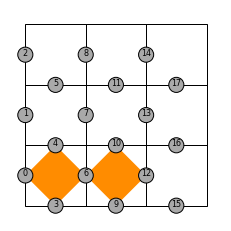

Pick action: 6


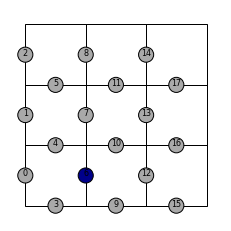

Combined with the original physical qubit errors, this is the total error string:


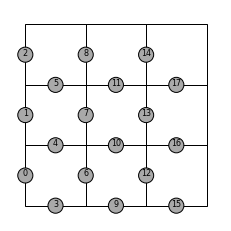

You win!


In [4]:
# Initialize a game that is not already solved
obs = env.reset()
    
# Render the initial state
env.render()

done = False
while not done:
    action = int(input("Pick action: "))
    obs, reward, done, info = env.step(action)
    env.render()

print("Combined with the original physical qubit errors, this is the total error string:")
for q in env.initial_qubits_flips[0]:
    env.state.act(q, 0, update_syndrome=False)
env.render()
    
if reward == 1:
    print("You win!")
else: 
    print("You've lost")